In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import DualwormFunctions as dw
import Observables as obs
%load_ext line_profiler
%load_ext memory_profiler
import RunBasis
import argparse
import StartStates as strst
import numpy as np
import AnalysisFunctions as af # functions to make the analysis code cleaner
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
nst = 1024;
nsm = 32;
nips = 10;
nb = 8;
measperiod = 1;
J1 = -1
J2 = -0.25
J3 = 1

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = 6, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = J3,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling')
    parser.add_argument('--h', type = float, default = 0.0,
                        help = 'Magnetic field')    
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = 4,
                        help = 'number of threads to use')

    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = 10,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with the maximally magnetised GS''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--p', type = float, default = 0.0, 
                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.01,30],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [64],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    
    #CORRELATIONS PARAMETER
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = False, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--magnstats', default = False, action = 'store_true', 
                       help = 'activate if you want to compute the magnetisation statistics')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--correlations', default = False, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--all_correlations', default = False, action = 'store_true',
                        help = '''activate if you want to save the correlations for all non-equivalent
                        pairs of sites. Otherwise, will save central correlations.''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    #SAVE
    parser.add_argument('--output', type = str, default = "testGS", help = 'saving filename (.pkl will be added)')
    args = parser.parse_args()
    return args

In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
meanstat, failedupdatesth, failedupdates = callRunBasis()
print("Everything seems to be running smoothly")

Lattice side size:  6
J1  -1
J2  -0.25
J3  1
J3st  1
h 0.0
Couplings exacted
dw.Hamiltonian done
hamiltonian computed
0 64
Number of temperatures:  64
Fully random initialisation =  True
Identical initialisation =  False
Magnetisation initialisation =  False
{'random': True, 'h': 0.0, 'magninit': False, 'same': False}
Same initialisation for all temperatures =  False
True
List of measurements to be performed: ['Energy']
List of temperature indices to measure: range(0, 64)
-----------Thermalisation------------------
Number of thermalisation steps =  1024
itermcs =  1024
magnstats False
statsfunctions []
h =  0.0
Time for mcsevolve = 0.09536790591664612
Time for tempering = 0.0023124890867620707
Time for mapping to spins + computing statistics= 4.920642822980881e-06
Time for all thermalisation steps =  100.03443908691406
-----------Measurements-----------------
Number of measurement steps =  32
['Energy']
Measurement period: 1
itermcs =  32
magnstats False
statsfunctions [<function energ

In [7]:
# Create a folder to save the pictures
foldername = ''
results_foldername = 'Results/'
os.makedirs('./' + foldername + 'Plots' + results_foldername, exist_ok = True)

filenamelist = ['testGS']
n = len(filenamelist)

In [8]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures, nt, stat_temps, 
 temperatures_plots, listfunctions, sref] = af.LoadParameters(foldername, filenamelist)

In [9]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_MeanE, t_MeanEsq, t_varMeanE, t_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites, nb,
               stat_temps, temperatures, listfunctions, **kw)

In [10]:
print(t_MeanE[0])
print(6/7*J1[0] -2/7*J2[0] - J3[0])

[-1.54320988 -1.5308642  -1.5308642  -1.52777778 -1.52777778 -1.52777778
 -1.52469136 -1.52469136 -1.52469136 -1.52469136 -1.52469136 -1.52469136
 -1.52469136 -1.52469136 -1.52440201 -1.52189429 -1.52160494 -1.52160494
 -1.52160494 -1.52150849 -1.52112269 -1.52054398 -1.51957948 -1.51842207
 -1.51813272 -1.51803627 -1.51736111 -1.51610725 -1.5154321  -1.51417824
 -1.51244213 -1.50993441 -1.50395448 -1.49189815 -1.47289738 -1.45158179
 -1.40364583 -1.37741127 -1.33323688 -1.27662037 -1.22048611 -1.1791088
 -1.13126929 -1.05642361 -0.99151235 -0.94087577 -0.87075617 -0.77662037
 -0.74594907 -0.69077932 -0.62094907 -0.55864198 -0.5316358  -0.42390046
 -0.45322145 -0.38618827 -0.35570988 -0.30034722 -0.3054591  -0.24845679
 -0.22935957 -0.21691744 -0.15972222 -0.18296682]
-1.7857142857142856


Verifying that the low temperatures of file  testGS correspond to the ground state.
Phase 1:  False
Phase 2:  False
Phase 3:  False
Phase 4:  False
Phase 5:  False
Phase 6:  False
Phase 7:  False
Phase 8:  False
Phase 9:  False
Phase 10:  Problem!!
Phase 11:  False


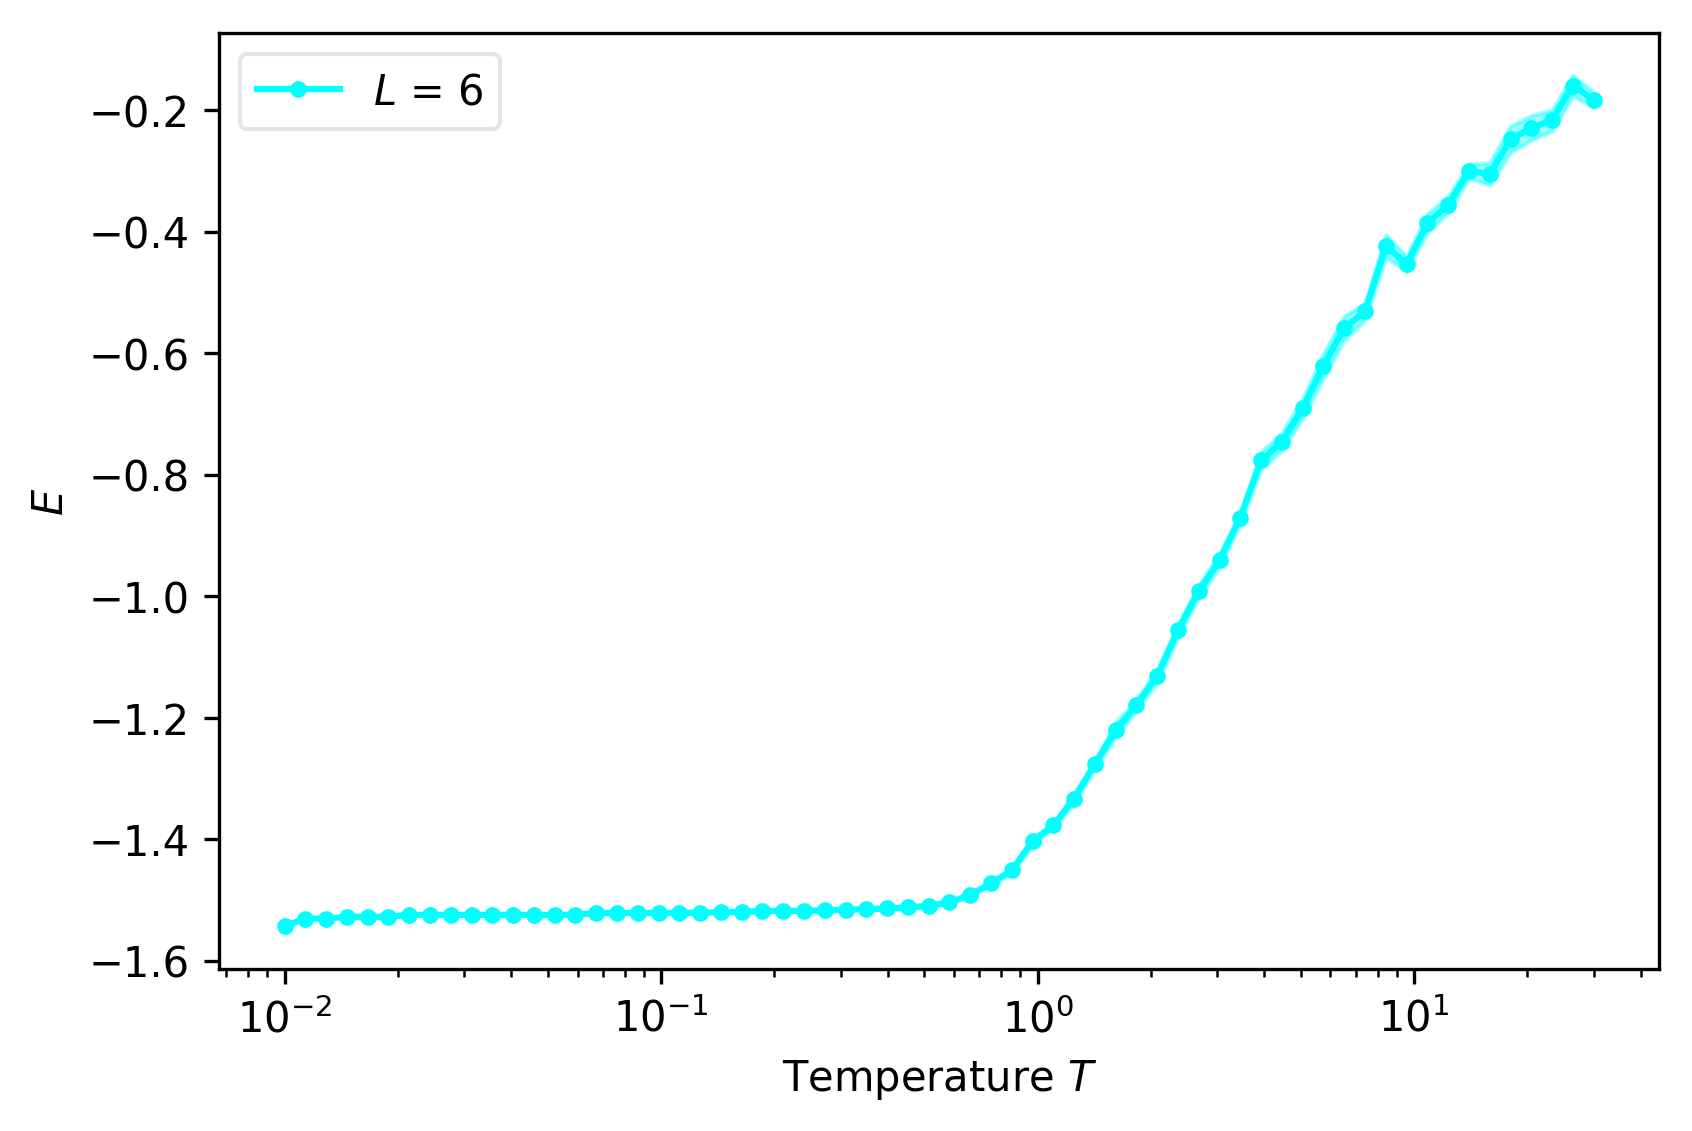

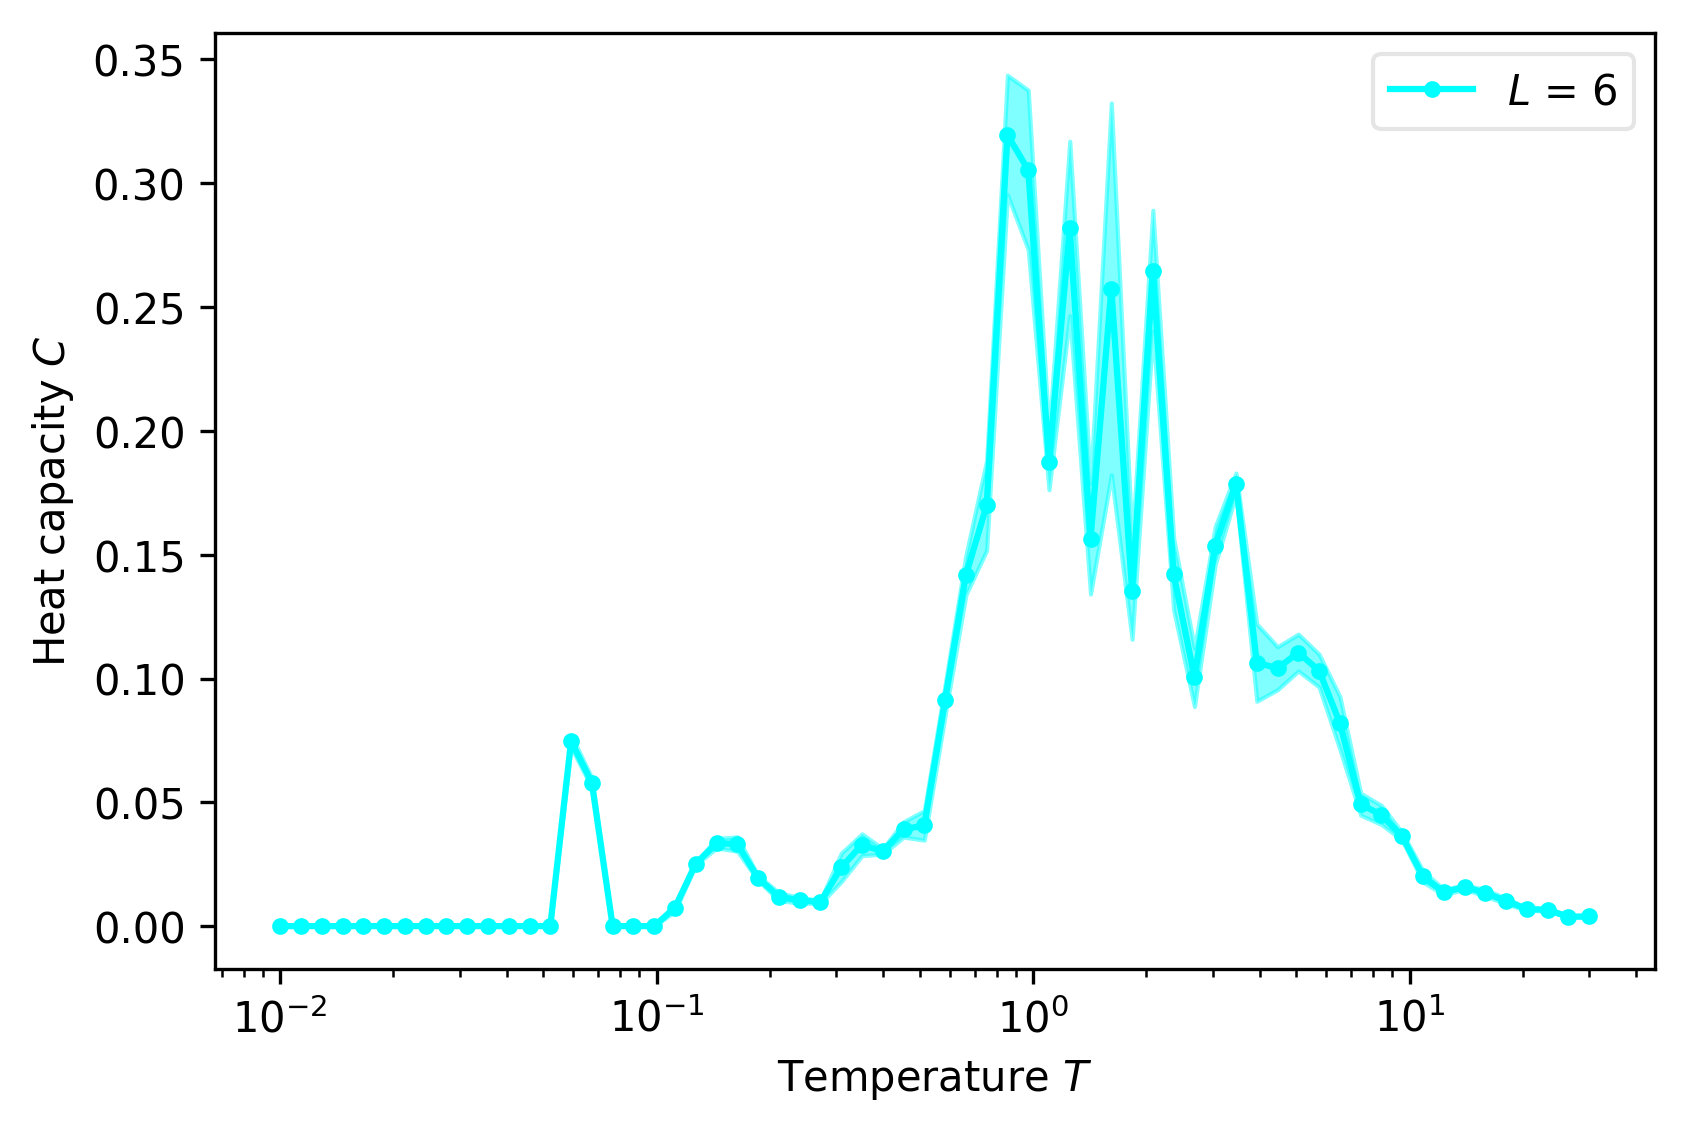

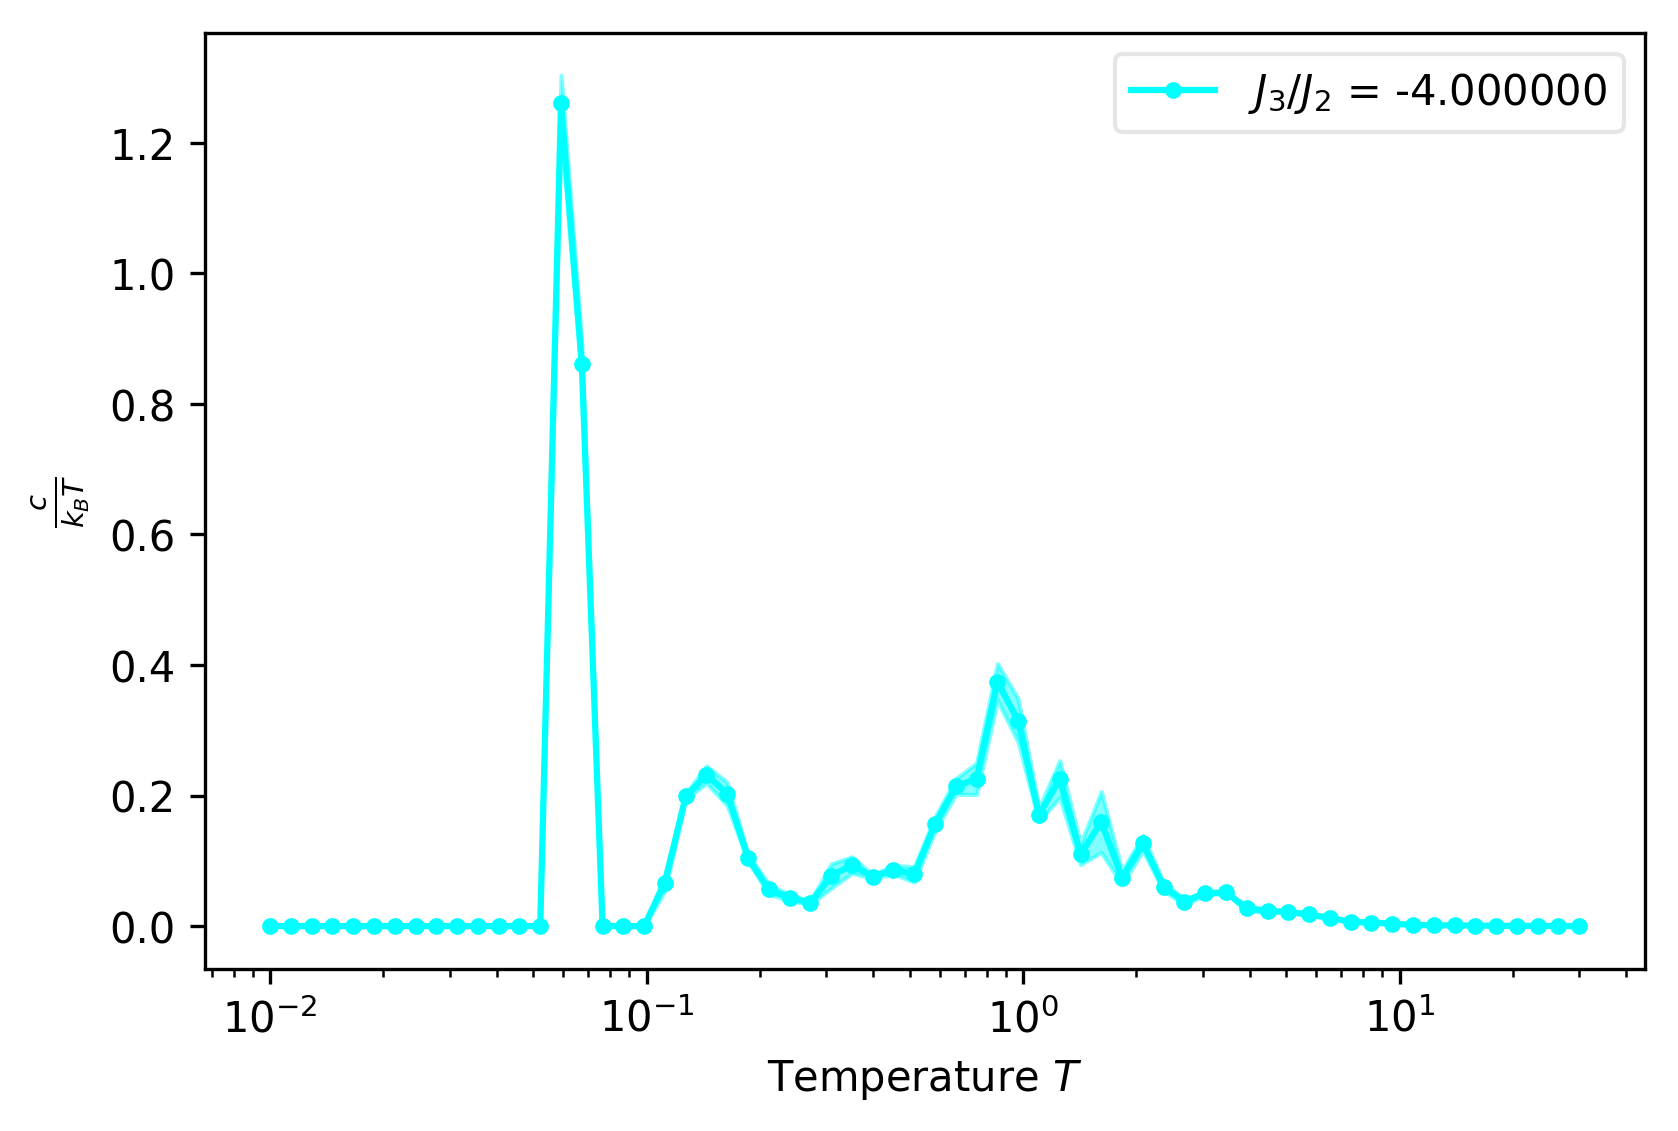

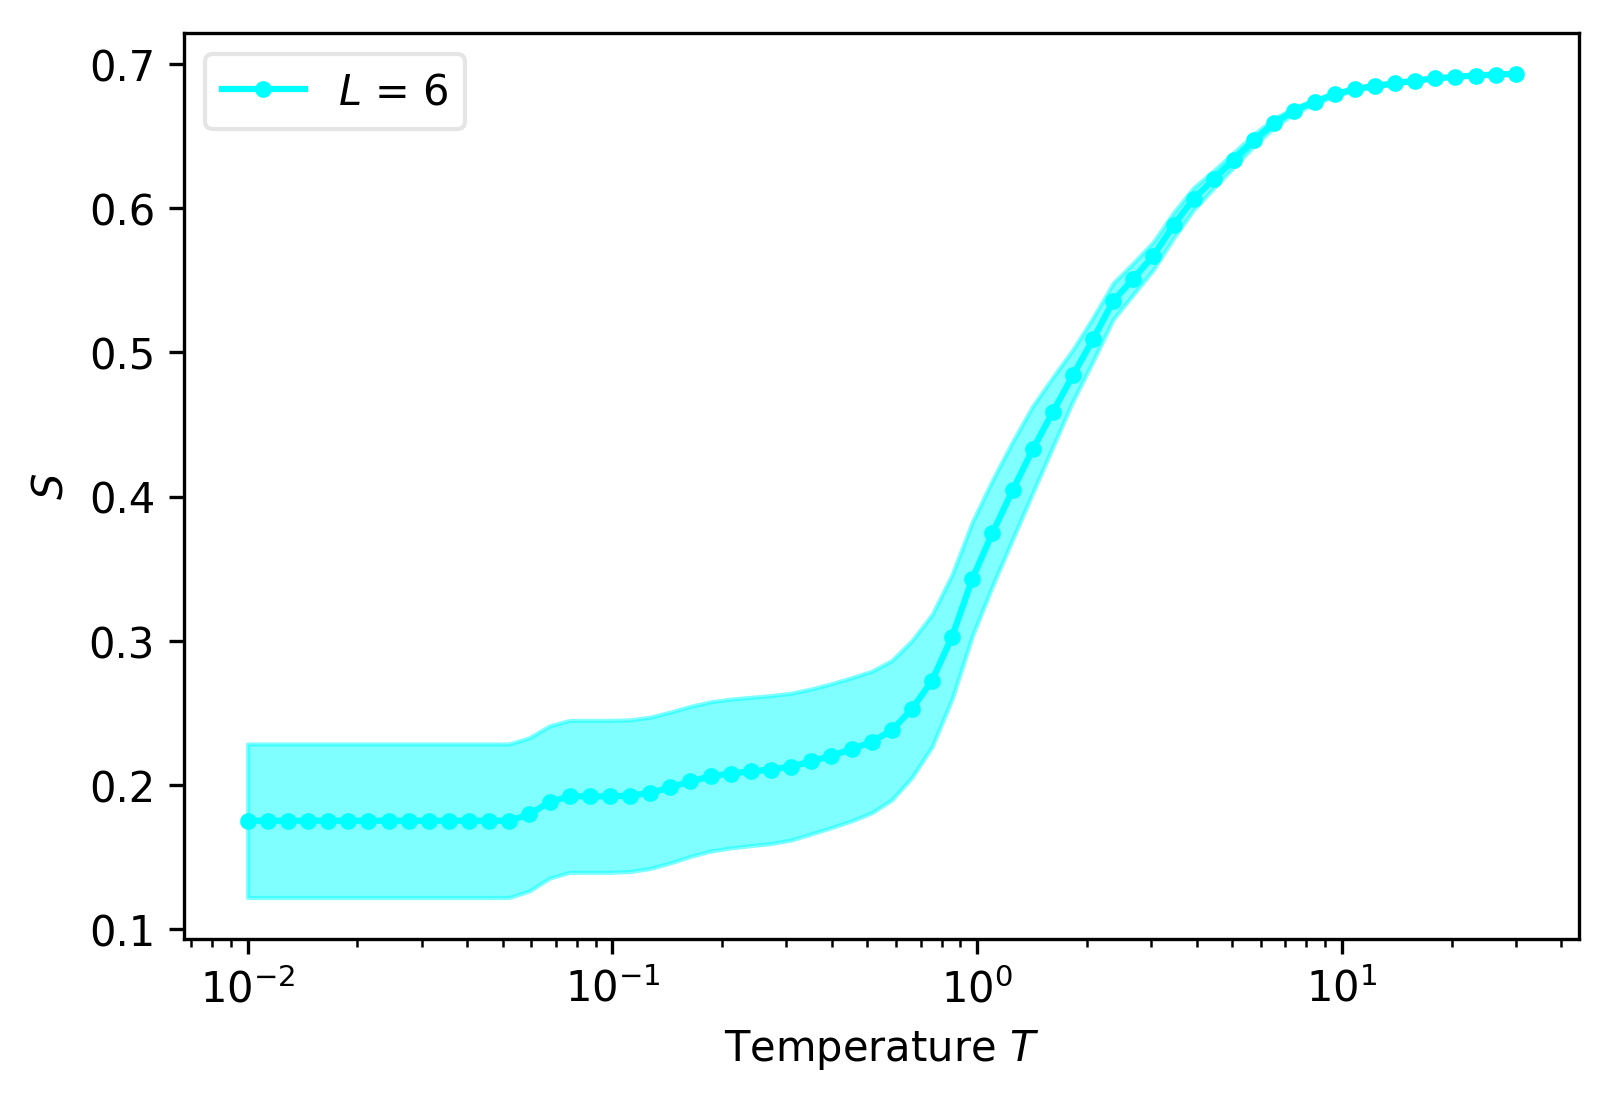

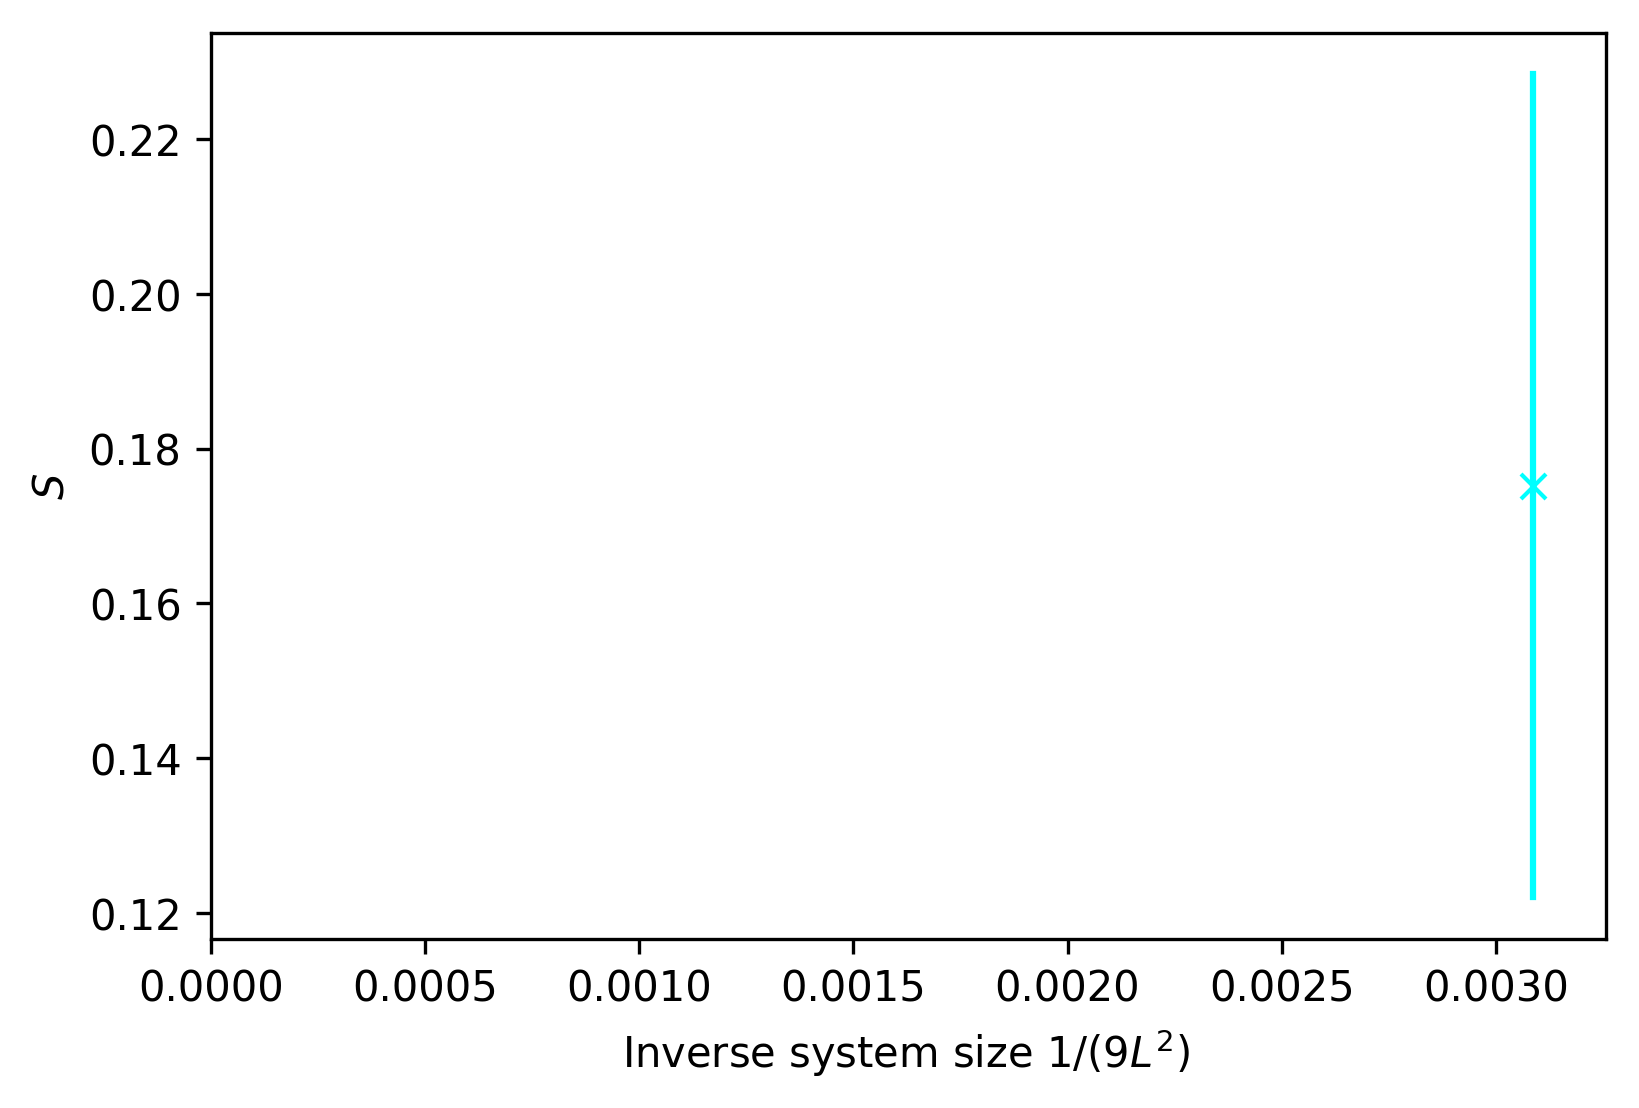

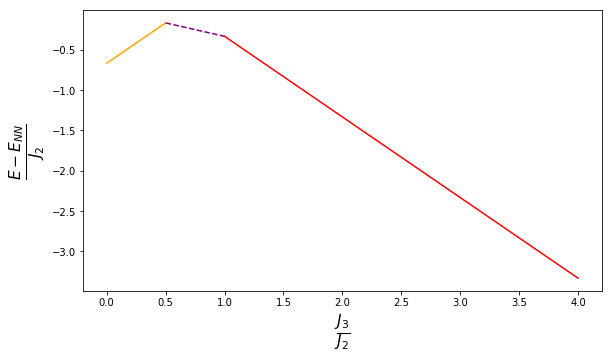

In [11]:
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, foldername, results_foldername, filenamelist, t_MeanE, t_MeanEsq, t_varMeanE, t_varMeanEsq, C, ErrC, J1, J2, J3, J4, S0)